In [1]:
!pip install albucore==0.0.16

In [2]:
import os
import torch
import timm

import terratorch
from terratorch.tasks import ClassificationTask, PixelwiseRegressionTask, SemanticSegmentationTask

from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples, GeoDataset, UnionDataset
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler,GeoSampler,RandomBatchGeoSampler

import terratorch.models.backbones.prithvi_vit as prithvi_vit
from terratorch.datamodules import GenericNonGeoSegmentationDataModule, GenericNonGeoClassificationDataModule
import pandas as pd
from torch.utils.data import DataLoader, ConcatDataset, RandomSampler

import tqdm
import rasterio as rio
import numpy as np
import pandas as pd

from rasterio.enums import Resampling

from data_preprocessing import create_split, crop_image_and_segmentation

#For tim
if 'UCProjectGroup1' in os.getcwd():
    os.chdir('..')

c:\Users\timvd\anaconda3\envs\UC-env-2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.24 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [3]:
print(timm.list_pretrained())
print(help(terratorch.tasks.ClassificationTask))

['bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k', 'beit_large_patch16_224.in22k_ft_in22k_in1k', 'beit_large_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_512.in22k_ft_in22k_in1k', 'beitv2_base_patch16_224.in1k_ft_in1k', 'beitv2_base_patch16_224.in1k_ft_in22k', 'beitv2_base_patch16_224.in1k_ft_in22k_in1k', 'beitv2_large_patch16_224.in1k_ft_in1k', 'beitv2_large_patch16_224.in1k_ft_in22k', 'beitv2_large_patch16_224.in1k_ft_in22k_in1k', 'botnet26t_256.c1_in1k', 'caformer_b36.sail_in1k', 'caformer_b36.sail_in1k_384', 'caformer_b36.sail_in22k', 'caformer_b36.sail_in22k_ft_in1k', 'caformer_b36.sail_in22k_ft_in1k_384', 'caformer_m36.sail_in1k', 'caformer_m36.sail_in1k_384', 'caformer_m36.sail_in22k', 'caformer_m36.sail_in22k_ft_in1k', 'caformer_m36.sail_in22k_ft_in1k_384', 'caformer_s18.sail_in1k', 'caformer_s18.sail_in1k_384', 'caformer_s

## Classification - Finetune Prithvi to act as a classification model

## Training model

Part 1: Constructing custom RasterDataset to transform our data to useable format

### Part 0: Data preprocessing

In [4]:
# Creating train-validation-test split
data_path =  os.path.join(os.getcwd(), "data") 
labels = pd.read_csv(os.path.join(data_path,'labels.csv')) 

label_filenames = labels['filename'].values
new_label_filenames = [l.replace(":","_") for l in label_filenames]
labels['filename'] = new_label_filenames

train, val, test= create_split(labels)
data_split ={"training":train, "validation":val, "test":test}
print(data_split["training"].shape, data_split["validation"].shape, data_split["test"].shape)

(1705,) (212,) (214,)


In [8]:
default_transform = rio.transform.from_bounds(0, 0, 120, 120, width=120, height=120)


path = os.getcwd()  # current path

datadir = os.path.join(path, "data","images","images")
reg_file = os.path.join(path, "data","labels.csv")
seglabeldir = os.path.join(path, "data","labels") # directory where segmentation masks are stored as tifs with the same filename as the image it pertains to
# examples = pd.read_csv(dataset_dir / f'{split}.csv')
examples = pd.read_csv(reg_file)  # extracting data from .csv
labels = examples['filename'].values
labels = [l.replace(":","_") for l in labels]  # reformatting filenames in labels.csv
examples['filename'] = labels
print(labels)

for split in data_split.keys():  # 'validation'

    # Create class dirs
    class_names = examples['fuel_type'].unique()  # defining classes 
    for class_name in class_names:
        os.makedirs(f'{path}/data/{split}/{class_name}', exist_ok=True)  # create new directories for train-validation sets

    # if split == 'training':
    #     # file_root = os.path.join(datadir, split, '120x120')  # only focus on the 120x120 in training for now
    #     file_root = os.path.join(datadir, split)  # use all images
    # else: 
    #     file_root = os.path.join(datadir, split)  # only 120x120 images in validation    


CROP_FLAG = True #This controls whether we crop all images to 120x120 or rescale them to 224x224 with bilinear resampling.

for dirpath,dirnames,files in tqdm(os.walk(datadir)):
    for file in files:
        if not file.endswith('.tif'):  # dont need to add file if not a tiff
            continue
        filepath = os.path.join(dirpath,file)

        seg_filepath = os.path.join(seglabeldir,file) #segmentation labels are stored in seglabeldir with the same filename

        if file in data_split["training"]:
            split = "training"
        elif file in data_split["validation"]:
            split = "validation"
        elif file in data_split["test"]:
            split = "test"
        else: 
            print("File is not in the list" )
        # print(file)
        
        if not CROP_FLAG:

            with rio.open(filepath) as src:  # open file to write to new directory
                load_file = src.read(
                    out_shape=(
                    src.count,
                    224,
                    224
                    ),
                resampling=Resampling.bilinear
                )
        
        else:
            #use crop functionality to load in the data. Works for both 120x120 and 300x300 and returns a 120x120 image. Also pass along the seg_filepath 
            #so that we know if we should interpolate spatial resolution or not
            load_file, _ = crop_image_and_segmentation(filepath, seg_filepath) # also returns cropped segmentation mask but we do not need it here so dump it in _

        # Stack bands (to match Prithvi channels)
        # BLUE, GREEN, RED, NIR_NARROW, SWIR_1, SWIR_2 / Landsat: B02, B03, B04, B05, B06, B07
        # Note that you don't have to match the channels, you can also define them in the config.
        # stacked = np.concatenate([rgb[[2, 1, 0]], ir.transpose((2, 0, 1))], axis=0)
        # stacked = np.concatenate([band for band in ])

        # Save images in dedicated folder per class
        # out_file = dataset_dir / split / row['label'] / f'{split}_{i}.tif'
        if np.isin(file,labels):  # checking if file is present in .csv
            file_csv = examples[examples['filename']==os.path.basename(os.path.normpath(file))]
            # file_label = examples.loc[i,['fuel_type']].values
            file_label = file_csv['fuel_type'].values[0]  # extract label
            # print(file_csv)
            file_index = file_csv.index[0]  # extract .csv index
            # out_file = f'data/{split}/{file_label}/{split}_{i}.tif'
            out_file = f'data/{split}/{file_label}/{split}_{file_index}.tif'  # new filepath
            # print(out_file)

            if not CROP_FLAG:
                with rio.open(out_file, 
                            'w',
                            driver='GTiff',
                            width=224,  # changed from 120
                            height=224,  # changed from 120
                            dtype=load_file.dtype,
                            transform=default_transform,  # Adding wrong geotransform to avoid NotGeoreferencedWarning
                            count=13) as dst:
                    dst.write(load_file)  # writing
            else:
                with rio.open(out_file, 
                            'w',
                            driver='GTiff',
                            width=120,  
                            height=120, 
                            dtype=load_file.dtype,
                            transform=default_transform,  # Adding wrong geotransform to avoid NotGeoreferencedWarning
                            count=13) as dst:
                    dst.write(load_file)  # writing



['0000__S2B-MSIL2A-ST20200122T111720-N0213-R137-T30UYV-20200122T122946.tif', '0046__S2B-MSIL2A-ST20200113T104630-N0213-R008-T32ULC-20200113T112959.tif', '0002__S2B-MSIL2A-ST20200122T111720-N0213-R137-T30UYV-20200122T122946.tif', '0000__S2A-MSIL2A-ST20200104T110726-N0213-R094-T30UYV-20200104T122020.tif', '0046__S2B-MSIL2A-ST20200113T104631-N0213-R008-T31UGT-20200113T112959.tif', '0057__S2A-MSIL2A-ST20200217T104629-N0214-R008-T32ULC-20200217T121511.tif', '0057__S2B-MSIL2A-ST20200212T104630-N0214-R008-T32ULC-20200213T134833.tif', '0000__S2A-MSIL2A-ST20200206T111719-N0214-R137-T30UYV-20200206T122704.tif', '0046__S2A-MSIL2A-ST20200207T104628-N0214-R008-T31UGT-20200207T122428.tif', '0046__S2A-MSIL2A-ST20200217T104630-N0214-R008-T31UGT-20200217T121511.tif', '0057__S2A-MSIL2A-ST20200207T104628-N0214-R008-T31UGT-20200207T122428.tif', '0042__S2A-MSIL2A-ST20200207T104627-N0214-R008-T32ULC-20200207T122428.tif', '0057__S2A-MSIL2A-ST20200207T104627-N0214-R008-T32ULC-20200207T122428.tif', '0046__S2A-

In [10]:
# count number of files in each folder after splitting
for split in data_split.keys():
    split_path = os.path.join(data_path, split)
    file_count = sum(len(files) for _, _, files in os.walk(split_path))
    print(f"{split}: {file_count} files")

training: 1705 files
validation: 212 files
test: 214 files


### Part 1: Defining datamodule for lightning trainer

In [7]:

# # Timm requires 224x224 input.
# train_transforms = albumentations.Compose([
#     albumentations.RandomCrop(height=224, width=224),
#     albumentations.HorizontalFlip(),
#     albumentations.pytorch.transforms.ToTensorV2(),
# ])
# val_transforms = albumentations.Compose([
#     albumentations.CenterCrop(height=224, width=224),
#     albumentations.pytorch.transforms.ToTensorV2(),
# ])

# means of full 13 bands
means_full=[
    960.97437, 1110.9012, 1250.0942, 1259.5178, 1500.98,
    1989.6344, 2155.846, 2251.6265, 2272.9438, 2442.6206,
    1914.3, 1512.0585, 1512.0585
    ]  # updated from dataset_multitask file, full
# means of 6 Prithvi bands
means=[1110.9012, 1250.0942, 1259.5178, 2251.6265, 1512.0585, 1512.0585]

# stds of full 13 bands
stds_full=[
    1302.0157, 1418.4988, 1381.5366, 1406.7112, 1387.4155,
    1438.8479, 1497.8815, 1604.1998, 1516.532, 1827.3025, 
    1303.83, 1189.9052, 1189.9052
    ]  # updated from dataset_multitask file 
# stds of 6 Prithvi bands
stds=[1418.4988, 1381.5366, 1406.7112, 1604.1998, 1189.9052, 1189.9052]

datamodule = GenericNonGeoClassificationDataModule(
    batch_size=16,
    num_workers=27,
    train_data_root=os.path.join(path, 'data', 'training'),
    val_data_root=os.path.join(path, 'data', 'validation'),
    test_data_root=os.path.join(path, 'data', 'test'), 
    means=means,
    stds=stds,
    num_classes=6,

    # if transforms are defined with Albumentations, you can pass them here
    # train_transform=train_transforms,
    # val_transform=val_transforms,
    # test_transform=val_transforms,

    # Bands of your dataset (in this case similar to the model bands)
    dataset_bands=('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B010', 'B011', 'B012', 'B013'),
    # Input bands of your model
    # output_bands=('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B010', 'B011', 'B012', 'B013'),
    output_bands=('B02', 'B03', 'B04','B08','B012', 'B013'),
    constant_scale=39.216,  # Scale 0-255 data to 0-10000 (HLS data) (10000 / 255 = 39.216)
    no_data_replace=0,
)
# we want to access some properties of the train dataset later on, so lets call setup here
# if not, we would not need to
datamodule.setup("fit")

### Part 2: Defining classification error

In [22]:
pretrained_bands = prithvi_vit.PRETRAINED_BANDS  # need to still select the correct bands
path_weights = os.path.join(os.getcwd(), "Prithvi_EO_V1_100M.pt")

VIT_UPERNET_NECK = [
    {"name": "SelectIndices", "indices": [1, 2, 3, 4]},
    {"name": "ReshapeTokensToImage"},
    {"name": "LearnedInterpolateToPyramidal"},
]


model_args = {
        "in_channels": 13,
        "backbone": "prithvi_vit_100", # see timm.list_pretrained() 
        "decoder": "UperNetDecoder",
        # "bands": ('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B010', 'B011', 'B012', 'B013'),  # full
        "bands": ('B02', 'B03', 'B04','B08','B012', 'B013'),
        "backbone_pretrained_cfg_overlay":{"file": path_weights}, # FUCK THE EO PEOPLE ON HUGGINGFACE FOR RENAMING THE FILE YOU PIECES OF SHIT
        # "pretrained":False,
        # "pretrained":True,
        "num_classes": 6,
        "necks":  VIT_UPERNET_NECK
}

task = ClassificationTask(
    model_args=model_args,
    model_factory="PrithviModelFactory",
    # pretrained_cfg=dict(file="Prithvi_EO_V1_100M.pt"),
    loss="ce",  # cross-entropy loss for 
    lr=1e-4,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.05},
    freeze_backbone=False,
)

INFO:timm.models._builder:Loading pretrained weights from file (/vol/home/s2267063/UC Project/Prithvi_EO_V1_100M.pt)


RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

### Part 4: Training the model - Initialising and fitting lightning trainer

In [16]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint, RichProgressBar
from lightning.pytorch.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(monitor=task.monitor, save_top_k=1, save_last=True)
early_stopping_callback = EarlyStopping(monitor=task.monitor, min_delta=0.00, patience=20)
logger = TensorBoardLogger(save_dir='output', name='classification')

# You can also log directly to WandB
# from lightning.pytorch.loggers import WandbLogger
# wandb_logger = WandbLogger(log_model="all") 

trainer = Trainer(
    devices=1, # Number of GPUs. Interactive mode recommended with 1 device
    precision="16-mixed",
    callbacks=[
        RichProgressBar(),
        checkpoint_callback,
        early_stopping_callback,
        LearningRateMonitor(logging_interval="epoch"),
    ],
    logger=logger,
    max_epochs=10, # train only one epoch for demo
    default_root_dir='output/classification',
    log_every_n_steps=1,
    check_val_every_n_epoch=1
)
_ = trainer.fit(model=task, datamodule=datamodule)

c:\Users\alhst\anaconda3\envs\terratorch\Lib\site-packages\lightning\pytorch\trainer\connectors\accelerator_connector.py:556: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ScalarOutputModel │  106 M │
│ 1 │ criterion     │ CrossEntropyLoss  │      0 │
│ 2 │ train_metrics │ MetricCollection  │      0 │
│ 3 │ val_metrics   │ MetricCollection  │      0 │
│ 4 │ test_metrics  │ MetricCollection  │      0 │
└───┴───────────────┴───────────────────┴────────┘

Trainable params: 20.7 M                                                                                           
Non-trainable params: 86.2 M                                                                                       
Total params: 106 M                                                                                                
Total estimated model params size (MB): 427

c:\Users\alhst\anaconda3\envs\terratorch\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\alhst\anaconda3\envs\terratorch\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:4
41: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the
`num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

c:\Users\alhst\anaconda3\envs\terratorch\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:4
41: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of 
the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


### Part 5: Testing the finetuned model

In [18]:
res = trainer.test(model=task, datamodule=datamodule)

c:\Users\alhst\anaconda3\envs\terratorch\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\alhst\anaconda3\envs\terratorch\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test/Average_Accuracy     │      0.42962273955345154      │
│   test/Multiclass_F1_Score    │      0.3767123222351074       │
│ test/Multiclass_Jaccard_Index │      0.2354111671447754       │
│     test/Overall_Accuracy     │      0.3767123222351074       │
│           test/loss           │      1.3190964460372925       │
│   test/multiclassaccuracy_0   │      0.9545454382896423       │
│   test/multiclassaccuracy_1   │      0.0476190485060215       │
│   test/multiclassaccuracy_2   │      0.3163265287876129       │
│   test/multiclassaccuracy_3   │      0.4000000059604645       │
│ test/multiclassjaccardindex_0 │      0.19811320304870605      │
│ test/multiclassjaccardindex_1 │      0.04545454680919647      │
│ test/multiclassjaccardindex_2 │      0.29807692766189575      │
│ test/multiclassjaccardindex_3 │      0.4000000059604645       │
└───────────────────────────────┴───────────────────────────────┘

# Segmentation - Predicting segmentation cloud maps

### Processing the segmentation masks into the correct folders

In [ ]:
# checking number of channels in "labels"
with rio.open("data/labels/0000__S2A-MSIL2A-ST20200104T110726-N0213-R094-T30UYV-20200104T122020.tif", 'r') as src:
    help_test = src.read()
    print(help_test.shape)

In [8]:
# Rastering segmentation json files
import json
from shapely.geometry import Polygon
from rasterio.features import rasterize, geometry_mask
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt

if 'UCProjectGroup1' in os.getcwd():
    os.chdir('..')
path = os.getcwd()  # current path
data_path =  os.path.join(os.getcwd(), "data") 
datadir = os.path.join(path, "data","images","images")
seglabeldir = os.path.join(path, "data","segmentation_labels","segmentation_labels")

# create folder to host the new segmentation maps
os.makedirs(f'{path}/data/labels', exist_ok=True)
default_transform = rio.transform.from_bounds(0, 0, 120, 120, width=120, height=120)
seglabels = []
segfile_lookup = {}

# Make a lookup table for each segmentation file
idx = 0
for dirpath,dirnames,files in os.walk(seglabeldir):
    for seglabelfile in files:
        if not os.path.join(dirpath,seglabelfile).endswith(".json"):
            continue
        segdata = json.load(open(os.path.join(dirpath,
                                                seglabelfile), 'r'))
        seglabels.append(segdata)
        seg_key = "-".join(segdata['data']['image'].split('-')[1:]).replace(
                '.png', '.tif')
        seg_key = seg_key.replace(":","_")  # to match with image files
        segfile_lookup[seg_key] = idx
        # segfile_lookup[
        #     "-".join(segdata['data']['image'].split('-')[1:]).replace(
        #         '.png', '.tif')] = idx  # original code
        idx+=1
print(segfile_lookup.keys())

print(len(segfile_lookup.keys()))

# seglabels_poly = []

# counting number of positive segmentation maps with existing polygons
idx = 0
# Walking through all images and adding segmentation masks
for root, _, files in os.walk(datadir):
    for filename in files:
        if not filename.endswith('.tif'):
            continue
        # if filename not in segfile_lookup.keys():
        #     continue
        img_path = os.path.join(root, filename)

        # extracting image size
        if "120x120" in img_path:
            size = 120
        elif "300x300" in img_path:
            size = 300
        elif "validation" in img_path:
            size = 120
        else: 
            print("Outlier image size")  # detecting remaining outliers
            print(img_path)
            size = 120

        polygons = []
        if filename in segfile_lookup.keys():  # add polygons if clouds are present in image
            for completions in seglabels[segfile_lookup[filename]]['completions']:
                for result in completions['result']:
                    polygons.append(
                        np.array(
                            result['value']['points'] + [result['value']['points'][0]]) * size / 100)
        with rio.open(img_path, 'r') as src:  # reading image 
            img_file = src.read()

        # rasterize segmentation polygons
        fptdata = np.zeros((img_file.shape[1], img_file.shape[2]), dtype=np.uint8)
        # polygons = seglabels_poly.copy()
        shapes = []
        if len(polygons) > 0: # add polygons if clouds are present in images
            for pol in polygons:
                try:
                    pol = Polygon(pol)
                    shapes.append(pol)
                except ValueError:
                    continue
            polygon_geom = [(g, 1) for g in shapes]
            fptdata = rasterize(shapes,
                                out_shape=fptdata.shape,
                                all_touched=True)

        # convert raster to tiff 
        mask_name = f"data/labels/{filename}"
        with rio.open(mask_name, 
                    'w',
                    driver='GTiff',
                    width=size,
                    height=size,
                    dtype=fptdata.dtype,
                    transform=default_transform,  # Adding wrong geotransform to avoid NotGeoreferencedWarning
                    count=1) as dst:
            # dst.nodata = 1  # does this help?
            # dst.write_mask(True)  # does this help?
            dst.write(fptdata, 1)  # writing
        
        # if positive, plot corresponding segmentation map
        if size==120 and "positive" in img_path:
            print(fptdata[fptdata != 0])
            print(shapes)
            print(filename)
            # with rio.open(mask_name, 'r') as src:
            #     mask_file = src.read()
            #     fig, ax = plt.subplots()
            #     plt.imshow(mask_file[0, :, :], cmap='grey')
            #     plt.show()
            idx+=1

print(idx)

dict_keys(['10300_2019-01-19T10_16_47.036Z_0.tif', '10300_2019-01-21T10_06_47.315Z_1.tif', '10300_2019-02-05T10_06_51.130Z_2.tif', '10300_2019-02-08T10_16_47.445Z_3.tif', '10300_2019-02-15T10_06_50.651Z_4.tif', '10300_2019-02-18T10_16_46.827Z_5.tif', '10300_2019-04-01T10_09_39.344Z_7.tif', '10300_2019-04-04T10_32_48.774Z_8.tif', '10300_2019-04-09T10_23_28.503Z_9.tif', '10300_2019-04-16T10_13_22.231Z_10.tif', '10300_2019-04-21T10_21_39.451Z_11.tif', '10300_2019-04-26T10_06_57.907765Z_12.tif', '10300_2019-05-24T10_16_50.479Z_13.tif', '10300_2019-06-15T10_06_58.227Z_14.tif', '10300_2019-07-03T10_16_52.109Z_16.tif', '10300_2019-07-23T10_16_52.263Z_17.tif', '10300_2019-07-30T10_06_55.530Z_18.tif', '10300_2019-09-03T10_06_53.710Z_20.tif', '10300_2019-09-21T10_16_47.392Z_22.tif', '10300_2019-09-26T10_16_47.221Z_23.tif', '10300_2019-10-13T10_06_52.003Z_24.tif', '10300_2019-10-28T10_06_54.090Z_26.tif', '10300_2019-10-31T10_16_50.392Z_27.tif', '10300_2019-11-07T10_06_53.522Z_28.tif', '10300_2019

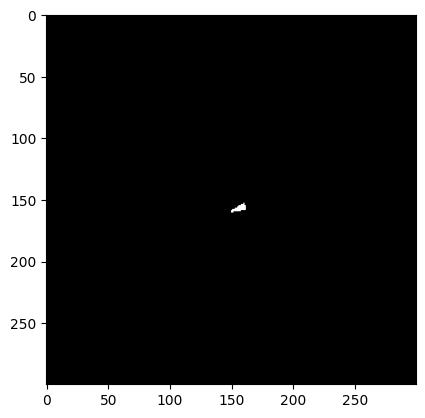

In [9]:
# Testing random segmentation mask
with rio.open(os.path.join("data","labels","0000__S2A-MSIL2A-ST20200317T111723-N0214-R137-T30UYV-20200317T123526.tif")) as test:
    test_file = test.read()
    fig, ax = plt.subplots()
    plt.imshow(test_file[0, :, :], cmap='grey')
    plt.show()

633
['10300_2019-01-19T10_16_47.036Z_0.tif', '10300_2019-01-21T10_06_47.315Z_1.tif', '10300_2019-02-05T10_06_51.130Z_2.tif', '10300_2019-02-08T10_16_47.445Z_3.tif', '10300_2019-02-15T10_06_50.651Z_4.tif', '10300_2019-02-18T10_16_46.827Z_5.tif', '10300_2019-04-01T10_09_39.344Z_7.tif', '10300_2019-04-04T10_32_48.774Z_8.tif', '10300_2019-04-09T10_23_28.503Z_9.tif', '10300_2019-04-16T10_13_22.231Z_10.tif']
['46405_2019-06-14T10_35_45.858Z_10.tif', '74662_2019-03-20T10_24_21.717Z_7.tif', '4951_2019-06-09T09_46_18.524Z_18.tif', '44290_2019-05-13T10_46_40.745Z_6.tif', '11284_2019-10-26T10_16_52.670Z_18.tif', '198_2019-06-15T10_06_47.171Z_19.tif', '46848_2019-04-22T10_30_33.139Z_7.tif', '6494_2019-04-18T10_07_15.833Z_3.tif', '74740_2019-07-18T10_16_50.396Z_26.tif', '44073_2019-11-29T10_46_49.215Z_15.tif', '198_2019-04-06T10_12_22.697Z_10.tif', '4951_2019-11-16T09_46_09.298Z_43.tif', '46848_2019-03-23T10_40_45.618Z_4.tif', '6306_2019-02-20T10_56_40.788Z_4.tif', '46251_2019-10-14T10_26_14.181Z_2

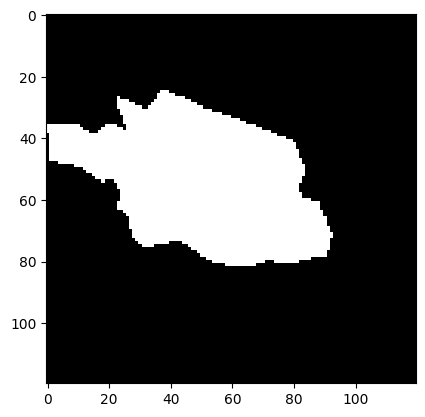

In [10]:
# Creating train-validation-test split based on available segmentation masks
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

seglabeldir = os.path.join(path, "data","segmentation_labels","segmentation_labels")
segmaskdir = os.path.join(path, "data","labels")
datadir = os.path.join(path, "data","images","images")
positive_labels = []
for root, _, files in os.walk(seglabeldir):
    for filename in files:
        if not filename.endswith('.json'):
            continue
        if '300' in root:
            continue
        positive_labels.append(filename.replace("_features.json",".tif"))
positive_labels = [l.replace(":","_") for l in positive_labels]
print(len(positive_labels))
print(positive_labels[:10])

segdata_shuffle = shuffle(positive_labels, random_state=42)
train_val, test = train_test_split(segdata_shuffle, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.11, random_state=42)
data_split ={"training":train, "validation":val, "test":test}
print(data_split["training"])
print(len(data_split["training"]), len(data_split["validation"]), len(data_split["test"]))

with rio.open(os.path.join("data","labels","10300_2019-01-19T10_16_47.036Z_0.tif"), 'r') as test:
    test_file = test.read()
    plt.imshow(test_file[0,:,:], cmap='grey')
    plt.show()

#### Moving the segmentation files to splits and cropping 300x300 files to 120x120

In [12]:
default_transform = rio.transform.from_bounds(0, 0, 120, 120, width=120, height=120)

path = os.getcwd()  # current path
os.makedirs(f'{path}/data/segmentation', exist_ok=True)  # make dir for segmentation data

# transforming data to allow terratorch to use it
for split in data_split.keys():  # 'validation'
    datadir = os.path.join(path, "data","images","images")
    reg_file = os.path.join(path, "data", "labels.csv")
    seglabeldir = os.path.join(path, "data,","segmentation_labels","segmentation_labels")
    # examples = pd.read_csv(dataset_dir / f'{split}.csv')
    examples = pd.read_csv(reg_file)  # extracting data from .csv
    labels = examples['filename'].values
    labels = [l.replace(":","_") for l in labels]  # reformatting filenames in labels.csv
    examples['filename'] = labels
    # print(labels)

    # Create class dirs
    class_names = ['negative', 'positive']  # defining classes (either contains clouds or does not)
    for class_name in class_names:
        # os.makedirs(f'{path}/data/segmentation/{split}/{class_name}', exist_ok=True)  # create new directories for train-validation sets
        os.makedirs(f'{path}/data/segmentation/{split}', exist_ok=True)
os.makedirs(f'{path}/data/segmentation/predict', exist_ok=True)
    # if split == 'training':
    #     # file_root = os.path.join(datadir, split, '120x120')  # only focus on the 120x120 in training for now
    #     file_root = os.path.join(datadir, split)  # use all images
    # else: 
    #     file_root = os.path.join(datadir, split)  # only 120x120 images in validation    

for dirpath,dirnames,files in os.walk(datadir):
    for file in files:
        if not file.endswith('.tif'):  # dont need to add file if not a tiff
            continue
        filepath = os.path.join(dirpath,file)  # image file

        segmentationpath = os.path.join(path, 'data', 'labels', file)  #corresponding segmentation file

        if file in data_split["training"]:
            split = "training"
        elif file in data_split["validation"]:
            split = "validation"
        elif file in data_split["test"]:
            split = "test"
        else: 
            # print("File is not in the list")
            continue  # comment out later
            # print(file)
        
        if '120' in filepath or 'validation' in filepath:  # simply open the files, validation is only 120x120 images
            
            with rio.open(filepath) as src1:  # open file to write to new directory
                load_file = src1.read(
                    out_shape=(
                    src1.count,
                    120,
                    120
                    )
                )
                
            with rio.open(segmentationpath) as src2:  # open file to write to new directory
                load_file_seg = src2.read(
                    out_shape=(
                    src2.count,
                    120,
                    120
                    )
                )
        
        elif '300' in filepath: # use cropping functionality to crop 300x300 to the central 120x120 square 
            load_file, load_file_seg = crop_image_and_segmentation(filepath, segmentationpath)

        else:
            print(f'{filepath} has invalid shape in filename, skipping.')
            continue

        # if file in segfile_lookup.keys():
        #     with rio.open(segmentationpath, 'r') as src:
        #             mask_file = src.read()
        #             fig, ax = plt.subplots()
        #             plt.imshow(mask_file[0, :, :], cmap='grey')
        #             plt.show()


        # Stack bands (to match Prithvi channels)
        # BLUE, GREEN, RED, NIR_NARROW, SWIR_1, SWIR_2 / Landsat: B02, B03, B04, B05, B06, B07
        # Note that you don't have to match the channels, you can also define them in the config.
        # stacked = np.concatenate([rgb[[2, 1, 0]], ir.transpose((2, 0, 1))], axis=0)
        # stacked = np.concatenate([band for band in ])

        # Save images in dedicated folder per class
        # out_file = dataset_dir / split / row['label'] / f'{split}_{i}.tif'
        if np.isin(file,labels):  # checking if file is present in .csv
            file_csv = examples[examples['filename']==os.path.basename(os.path.normpath(file))]
            file_index = file_csv.index[0]  # extract .csv index
            out_file = f'data/segmentation/{split}/{split}_{file_index}.img.tif'  # new filepath
            seg_out_file = f'data/segmentation/{split}/{split}_{file_index}.mask.tif'  # new filepath
            with rio.open(out_file, 
                        'w',
                        driver='GTiff',
                        width=120,  # change all to 120
                        height=120,  # change all to 120
                        dtype=load_file.dtype,
                        transform=default_transform,  # Adding wrong geotransform to avoid NotGeoreferencedWarning
                        count=13) as dst:
                dst.write(load_file)  # writing
            if split=='test':
                pred_file = f'data/segmentation/predict/predict_{file_index}.img.tif'
                with rio.open(pred_file, 
                                'w',
                                driver='GTiff',
                                width=120,  # change all to 120
                                height=120,  # change all to 120
                                dtype=load_file.dtype,
                                transform=default_transform,  # Adding wrong geotransform to avoid NotGeoreferencedWarning
                                count=13) as pst:
                        pst.write(load_file)  # writing
            with rio.open(seg_out_file, 
                        'w',
                        driver='GTiff',
                        width=120,  # change all to 120
                        height=120,  # change all to 120
                        dtype=load_file.dtype,
                        transform=default_transform,  # Adding wrong geotransform to avoid NotGeoreferencedWarning
                        count=1) as dst:
                dst.write(load_file_seg)  # writing

In [24]:
## Testing that no tif file is 300x300 in at training 

for file in os.listdir(r'.\data\segmentation\training'):
    filepath = os.path.join(r'.\data\segmentation\training',file)
    with rio.open(filepath,'r') as test:
        try:
            test_file = test.read()
        except:
            test_file = test.read(1)
        
        shape = test_file.shape[1:]
        if shape != (120,120):
            print(filepath)

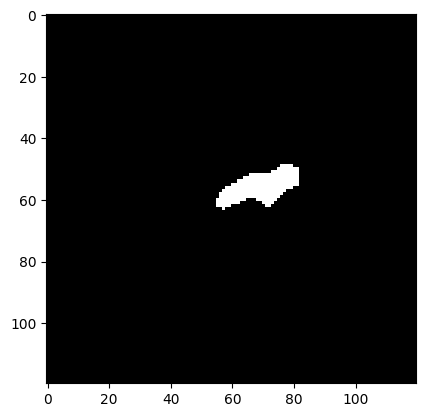

In [13]:
# Re-Testing random segmentation mask
with rio.open(os.path.join("data","segmentation", "training","training_1818.mask.tif")) as test:
    test_file = test.read()
    fig, ax = plt.subplots()
    plt.imshow(test_file[0, :, :], cmap='grey')
    plt.show()

In [13]:
pretrained_bands = prithvi_vit.PRETRAINED_BANDS  # need to still select the correct bands

VIT_UPERNET_NECK = [
    {"name": "SelectIndices", "indices": [1, 2, 3, 4]},
    {"name": "ReshapeTokensToImage"},
    {"name": "LearnedInterpolateToPyramidal"},
]

model_seg_args = {
        "in_channels": 6,
        "backbone": "prithvi_vit_100", # see timm.list_pretrained() 
        "decoder": "UperNetDecoder",
        # "bands": ('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B010', 'B011', 'B012', 'B013'),
        "bands": ('B02', 'B03', 'B04', 'B08','B012', 'B013'),
        "backbone_pretrained_cfg_overlay":{"file": "Prithvi_EO_V1_100M.pt"}, # FUCK THE EO PEOPLE ON HUGGINGFACE FOR RENAMING THE FILE YOU PIECES OF SHIT
        "pretrained":True,
        "num_classes": 2,
        "necks":  VIT_UPERNET_NECK
}

seg_task = SemanticSegmentationTask(
    model_args=model_seg_args,
    model_factory="PrithviModelFactory",
    loss="ce",
    lr=1e-4,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.05},
    freeze_backbone=False
)

In [44]:
means_full=[
    960.97437, 1110.9012, 1250.0942, 1259.5178, 1500.98,
    1989.6344, 2155.846, 2251.6265, 2272.9438, 2442.6206,
    1914.3, 1512.0585, 1512.0585
    ]  # updated from dataset_multitask file
means=[1110.9012, 1250.0942, 1259.5178, 2251.6265, 1512.0585, 1512.0585]

stds_full=[
    1302.0157, 1418.4988, 1381.5366, 1406.7112, 1387.4155,
    1438.8479, 1497.8815, 1604.1998, 1516.532, 1827.3025, 
    1303.83, 1189.9052, 1189.9052
    ]  # updated from dataset_multitask file 
stds=[1418.4988, 1381.5366, 1406.7112, 1604.1998, 1189.9052, 1189.9052]

datamodule_seg = GenericNonGeoSegmentationDataModule(
    batch_size=16,
    num_workers=7,
    train_data_root=os.path.join(path, 'data', 'segmentation','training'),
    val_data_root=os.path.join(path, 'data', 'segmentation', 'validation'),
    test_data_root=os.path.join(path, 'data', 'segmentation', 'test'),
    predict_data_root=os.path.join(path, 'data', 'segmentation', 'predict'),
    img_grep="*.img.tif",
    label_grep="*.mask.tif",
    means=means_full,
    stds=stds_full,
    num_classes=2,

    # if transforms are defined with Albumentations, you can pass them here
    # train_transform=train_transforms,
    # val_transform=val_transforms,
    # test_transform=val_transforms,

    # Bands originally present in data
    dataset_bands=('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B010', 'B011', 'B012', 'B013'),
    # Bands to be fed into the model
    # output_bands=('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B010', 'B011', 'B012', 'B013'),  # all 13 bands
    output_bands=('B02', 'B03', 'B04','B08','B012', 'B013'),  # 6 Prithvi bands
    constant_scale=39.216,  # Scale 0-255 data to 0-10000 (HLS data) (10000 / 255 = 39.216)
    no_data_replace=0,
    no_label_replace=-1
)
# we want to access some properties of the train dataset later on, so lets call setup here
# if not, we would not need to
datamodule_seg.setup("fit")

In [45]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint, RichProgressBar
from lightning.pytorch.loggers import TensorBoardLogger

checkpoint_callback_seg = ModelCheckpoint(monitor=seg_task.monitor, save_top_k=1, save_last=True)
early_stopping_callback_seg = EarlyStopping(monitor=seg_task.monitor, min_delta=0.00, patience=20)
logger_seg = TensorBoardLogger(save_dir='output', name='tutorial')

# You can also log directly to WandB
# from lightning.pytorch.loggers import WandbLogger
# wandb_logger = WandbLogger(log_model="all") 

trainer_seg = Trainer(
    devices=1, # Number of GPUs. Interactive mode recommended with 1 device
    precision="16-mixed",
    callbacks=[
        RichProgressBar(),
        checkpoint_callback_seg,
        early_stopping_callback_seg,
        LearningRateMonitor(logging_interval="epoch"),
    ],
    logger=logger_seg,
    max_epochs=30, # number of epochs
    default_root_dir='output/segmentation',
    log_every_n_steps=1,
    check_val_every_n_epoch=1  # evaluate validation set every epoch
)
_ = trainer_seg.fit(model=seg_task, datamodule=datamodule_seg)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
/vol/home/s2267063/.conda/envs/terratorch/lib/python3.11/site-packages/lightning/pytorch/plugins/precision/amp.py:55: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ PixelWiseModel   │  108 M │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │
│ 2 │ train_metrics │ MetricCollection │      0 │
│ 3 │ val_metrics   │ MetricCollection │      0 │
│ 4 │ test_metrics  │ MetricCollection │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 108 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 108 M                                                                                                
Total estimated model params size (MB): 433

Output()

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [48]:
res = trainer_seg.test(model=seg_task, datamodule=datamodule_seg)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/Multiclass_Accuracy       │         0.9757311344146729          │
│      test/Multiclass_F1_Score       │         0.9757311344146729          │
│    test/Multiclass_Jaccard_Index    │         0.7879348993301392          │
│ test/Multiclass_Jaccard_Index_Micro │         0.9526122808456421          │
│              test/loss              │         0.07701314240694046         │
│      test/multiclassaccuracy_0      │         0.9919580221176147          │
│      test/multiclassaccuracy_1      │         0.6870521903038025          │
│    test/multiclassjaccardindex_0    │         0.9748100638389587          │
│    test/multiclassjaccardindex_1    │         0.6010597348213196          │
└─────────────────────────────────────┴─────────────────────────────────────┘

In [81]:
datamodule_seg.setup("test")
seg_pred = trainer_seg.predict(model=seg_task, datamodule=datamodule_seg)

# def IOU(pred_mask, true_mask):
#     diff = pred_mask - true_mask
#     TP = len(diff[diff == 0])
#     FP = len(diff[diff == 1])
#     FN = len(diff[diff == -1])
#     if (TP + FP + FN) == 0:
#         print(pred_mask[true_mask!=0])
#     return TP / (TP + FP + FN)

def IOU(pred_mask, true_mask):
    pred = pred_mask.detach().cpu().numpy()
    true = true_mask[0,:,:]
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    # print(np.sum(intersection), np.sum(union))
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

pred_img = []
true_files = []
true_img = []
for batch in range(len(seg_pred)):
    for idx, image in enumerate(seg_pred[batch]):
        if idx%2==0:
            pred_img.extend(image)
        else:
            true_files.extend(image)
true_files = [l.replace("predict_", "test_") for l in true_files]
true_files = [l.replace(".img",".mask") for l in true_files]
true_files = [os.path.basename(l) for l in true_files]

test_path = os.path.join(path, 'data', 'segmentation', 'test')
for idx, file in enumerate(true_files):
    file_path = os.path.join(test_path, file)
    with rio.open(file_path, 'r') as src:
        load_true = src.read()
        iou_score = IOU(pred_img[idx], load_true)
        print(f'IOU for image {file} = {iou_score}')
        plt.imshow(pred_img[idx])
        plt.title(f'Prediction {file}')
        plt.show()
        plt.imshow(load_true[0,:,:])
        plt.title(f'Ground truth {file}')
        plt.show()

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

(13, 120, 120)
0.90625
(13, 120, 120)
0.7588075880758808
(13, 120, 120)
0.33415233415233414
(13, 120, 120)


IndexError: The shape of the mask [13, 120, 120] at index 0 does not match the shape of the indexed tensor [120, 120] at index 0

# Custom Regression Head

In [108]:
# Trying regression
from regression_tasks import RegressionTask

model_args = {
        "in_channels": 13,
        "backbone": "prithvi_vit_100", # see timm.list_pretrained() 
        "decoder": "UperNetDecoder",
        "bands": ('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B010', 'B011', 'B012', 'B013'),
        "backbone_pretrained_cfg_overlay":{"file": "C:/Users/alhst/Documents/AI Master/Urban Computing/Project/Prithvi/Files/Prithvi_EO_V1_100M.pt"}, # FUCK THE EO PEOPLE ON HUGGINGFACE FOR RENAMING THE FILE YOU PIECES OF SHIT
        "pretrained":False,
        "num_classes": 1,
        "necks":  VIT_UPERNET_NECK
}

task = RegressionTask(
    model_args=model_args,
    model_factory="PrithviModelFactory",
    # pretrained_cfg=dict(file="Prithvi_EO_V1_100M.pt"),
    loss="mse",  # need cross-entropy for 
    lr=1e-4,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.05},
    freeze_backbone=True,
)

KeyError: 'PrithviModelFactory'

In [ ]:
print(f"The model was pretrained on bands {task._timm_module.pretrained_bands}.\n The model is using bands {model._timm_module.model_bands}")